In [1]:
"""
HELIOS - LSTM Anomaly Detection Training (Kaggle Notebook)

Train LSTM model for reconciliation anomaly detection using Kaggle TPU.

Steps:
1. Generate synthetic dataset (10,000 hours)
2. Prepare sequences (60-minute windows)
3. Train LSTM on TPU
4. Evaluate model performance
5. Export to ONNX for production

Copy this entire file into a Kaggle notebook.
"""

'\nHELIOS - LSTM Anomaly Detection Training (Kaggle Notebook)\n\nTrain LSTM model for reconciliation anomaly detection using Kaggle TPU.\n\nSteps:\n1. Generate synthetic dataset (10,000 hours)\n2. Prepare sequences (60-minute windows)\n3. Train LSTM on TPU\n4. Evaluate model performance\n5. Export to ONNX for production\n\nCopy this entire file into a Kaggle notebook.\n'

In [2]:

# ============================================================================
# SECTION 1: Install Dependencies & Setup
# ============================================================================

# Install required packages
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn tf2onnx onnx onnxruntime -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("✅ Dependencies installed")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"TPU available: {len(tf.config.list_physical_devices('TPU')) > 0}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 85.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires 

2025-12-17 02:34:20.072346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765938860.303204      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765938860.371020      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Dependencies installed
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TPU available: False


In [3]:
# ============================================================================
# SECTION 2: Synthetic Dataset Generation
# ============================================================================

def generate_normal_metrics(num_samples):
    """Generate normal reconciliation metrics."""
    data = {
        'missing_event_rate': np.random.normal(0.02, 0.005, num_samples).clip(0, 1),
        'duplicate_rate': np.random.normal(0.005, 0.002, num_samples).clip(0, 1),
        'inconsistent_rate': np.random.normal(0.003, 0.001, num_samples).clip(0, 1),
        'aws_gcp_latency_ms': np.random.normal(45, 7, num_samples).clip(10, 200),
        'aws_azure_latency_ms': np.random.normal(50, 8, num_samples).clip(10, 200),
        'gcp_azure_latency_ms': np.random.normal(42, 6, num_samples).clip(10, 200),
        'event_rate_per_minute': np.random.normal(1250, 150, num_samples).clip(100, 5000),
        'payload_size_variance': np.random.normal(0.1, 0.03, num_samples).clip(0, 1),
    }
    return pd.DataFrame(data)


def inject_anomaly_missing_events(df, start_idx, duration_minutes):
    """Inject missing event anomaly."""
    end_idx = min(start_idx + duration_minutes, len(df))
    df.loc[start_idx:end_idx, 'missing_event_rate'] = np.random.uniform(0.15, 0.30, end_idx - start_idx + 1)
    df.loc[start_idx:end_idx, 'event_rate_per_minute'] *= np.random.uniform(0.5, 0.7)
    df.loc[start_idx:end_idx, 'aws_gcp_latency_ms'] *= np.random.uniform(1.5, 2.5)
    df.loc[start_idx:end_idx, 'aws_azure_latency_ms'] *= np.random.uniform(1.5, 2.5)
    return df


def inject_anomaly_latency_spike(df, start_idx, duration_minutes):
    """Inject latency spike anomaly."""
    end_idx = min(start_idx + duration_minutes, len(df))
    df.loc[start_idx:end_idx, 'aws_gcp_latency_ms'] *= np.random.uniform(3, 5)
    df.loc[start_idx:end_idx, 'aws_azure_latency_ms'] *= np.random.uniform(3, 5)
    df.loc[start_idx:end_idx, 'gcp_azure_latency_ms'] *= np.random.uniform(3, 5)
    df.loc[start_idx:end_idx, 'missing_event_rate'] *= np.random.uniform(1.5, 2.0)
    df.loc[start_idx:end_idx, 'event_rate_per_minute'] *= np.random.uniform(0.8, 0.9)
    return df


def inject_anomaly_duplicate_storm(df, start_idx, duration_minutes):
    """Inject duplicate event storm."""
    end_idx = min(start_idx + duration_minutes, len(df))
    df.loc[start_idx:end_idx, 'duplicate_rate'] = np.random.uniform(0.05, 0.15, end_idx - start_idx + 1)
    df.loc[start_idx:end_idx, 'event_rate_per_minute'] *= np.random.uniform(1.3, 1.8)
    df.loc[start_idx:end_idx, 'payload_size_variance'] *= np.random.uniform(2, 3)
    return df


def inject_anomaly_inconsistency_spike(df, start_idx, duration_minutes):
    """Inject payload inconsistency anomaly."""
    end_idx = min(start_idx + duration_minutes, len(df))
    df.loc[start_idx:end_idx, 'inconsistent_rate'] = np.random.uniform(0.03, 0.10, end_idx - start_idx + 1)
    df.loc[start_idx:end_idx, 'payload_size_variance'] *= np.random.uniform(3, 5)
    df.loc[start_idx:end_idx, 'missing_event_rate'] *= np.random.uniform(1.2, 1.5)
    return df


def inject_anomaly_traffic_surge(df, start_idx, duration_minutes):
    """Inject traffic surge anomaly."""
    end_idx = min(start_idx + duration_minutes, len(df))
    df.loc[start_idx:end_idx, 'event_rate_per_minute'] *= np.random.uniform(3, 5)
    df.loc[start_idx:end_idx, 'aws_gcp_latency_ms'] *= np.random.uniform(1.5, 2.5)
    df.loc[start_idx:end_idx, 'aws_azure_latency_ms'] *= np.random.uniform(1.5, 2.5)
    df.loc[start_idx:end_idx, 'gcp_azure_latency_ms'] *= np.random.uniform(1.5, 2.5)
    df.loc[start_idx:end_idx, 'missing_event_rate'] *= np.random.uniform(2, 4)
    return df


def generate_dataset(num_hours=10000, anomaly_probability=0.02):
    """Generate complete synthetic dataset."""

    num_samples = num_hours * 60  # 1 sample per minute

    print(f"Generating {num_hours:,} hours ({num_samples:,} minutes) of data...")

    # Generate normal baseline
    df = generate_normal_metrics(num_samples)

    # Add timestamp
    start_time = datetime(2024, 1, 1, 0, 0, 0)
    df['timestamp'] = [start_time + timedelta(minutes=i) for i in range(num_samples)]

    # Initialize labels
    df['is_anomaly'] = 0
    df['anomaly_type'] = 'none'

    # Inject anomalies
    anomaly_types = [
        ('missing_events', inject_anomaly_missing_events, (15, 45)),
        ('latency_spike', inject_anomaly_latency_spike, (10, 30)),
        ('duplicate_storm', inject_anomaly_duplicate_storm, (5, 20)),
        ('inconsistency_spike', inject_anomaly_inconsistency_spike, (10, 40)),
        ('traffic_surge', inject_anomaly_traffic_surge, (20, 60)),
    ]

    anomaly_count = 0
    i = 0

    while i < num_samples:
        if random.random() < anomaly_probability:
            anomaly_type, inject_func, duration_range = random.choice(anomaly_types)
            duration = random.randint(*duration_range)
            duration = min(duration, num_samples - i)

            df = inject_func(df, i, duration)
            df.loc[i:i+duration, 'is_anomaly'] = 1
            df.loc[i:i+duration, 'anomaly_type'] = anomaly_type

            anomaly_count += 1
            i += duration + random.randint(30, 120)
        else:
            i += 60

    # Add time features
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    total_anomaly_minutes = df['is_anomaly'].sum()
    anomaly_rate = total_anomaly_minutes / len(df) * 100

    print(f"\n{'='*60}")
    print(f"Dataset Generation Complete!")
    print(f"{'='*60}")
    print(f"Total samples: {len(df):,} minutes")
    print(f"Total anomalies: {anomaly_count:,} events")
    print(f"Anomaly minutes: {total_anomaly_minutes:,} ({anomaly_rate:.2f}%)")
    print(f"Normal minutes: {len(df) - total_anomaly_minutes:,} ({100-anomaly_rate:.2f}%)")

    return df


# Generate dataset
print("\n🔄 Generating synthetic dataset...")
df = generate_dataset(num_hours=10000, anomaly_probability=0.02)

print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n📋 First 5 rows:")
print(df.head())

print(f"\n📈 Anomaly distribution:")
print(df['anomaly_type'].value_counts())




🔄 Generating synthetic dataset...
Generating 10,000 hours (600,000 minutes) of data...

Dataset Generation Complete!
Total samples: 600,000 minutes
Total anomalies: 175 events
Anomaly minutes: 4,592 (0.77%)
Normal minutes: 595,408 (99.23%)

📊 Dataset shape: (600000, 13)

📋 First 5 rows:
   missing_event_rate  duplicate_rate  inconsistent_rate  aws_gcp_latency_ms  \
0            0.017218        0.006755           0.003797           35.665733   
1            0.011484        0.005065           0.002990           56.747632   
2            0.028668        0.004956           0.002616           43.725350   
3            0.020833        0.004316           0.004050           38.602618   
4            0.014544        0.004777           0.003080           45.538435   

   aws_azure_latency_ms  gcp_azure_latency_ms  event_rate_per_minute  \
0             52.429896             30.630682            1283.387696   
1             47.499198             36.720395            1285.749129   
2             


📊 Visualizing data...


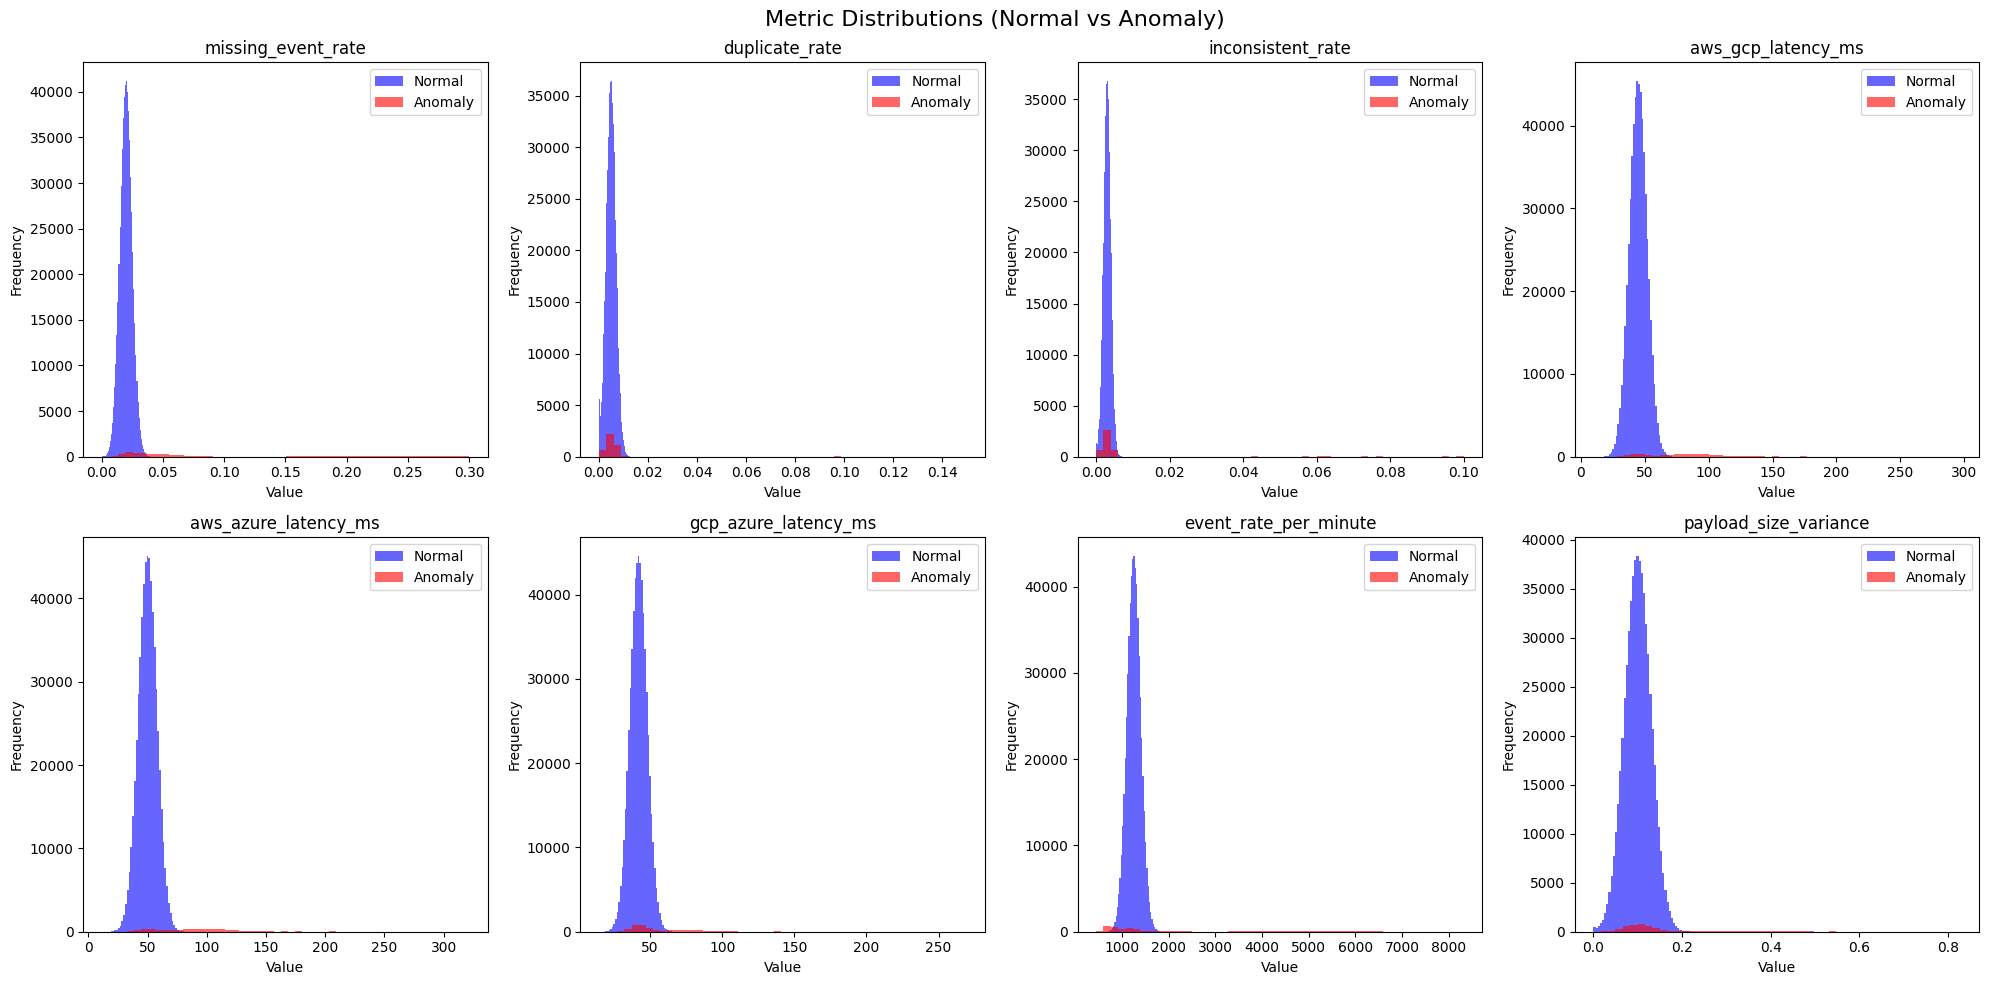

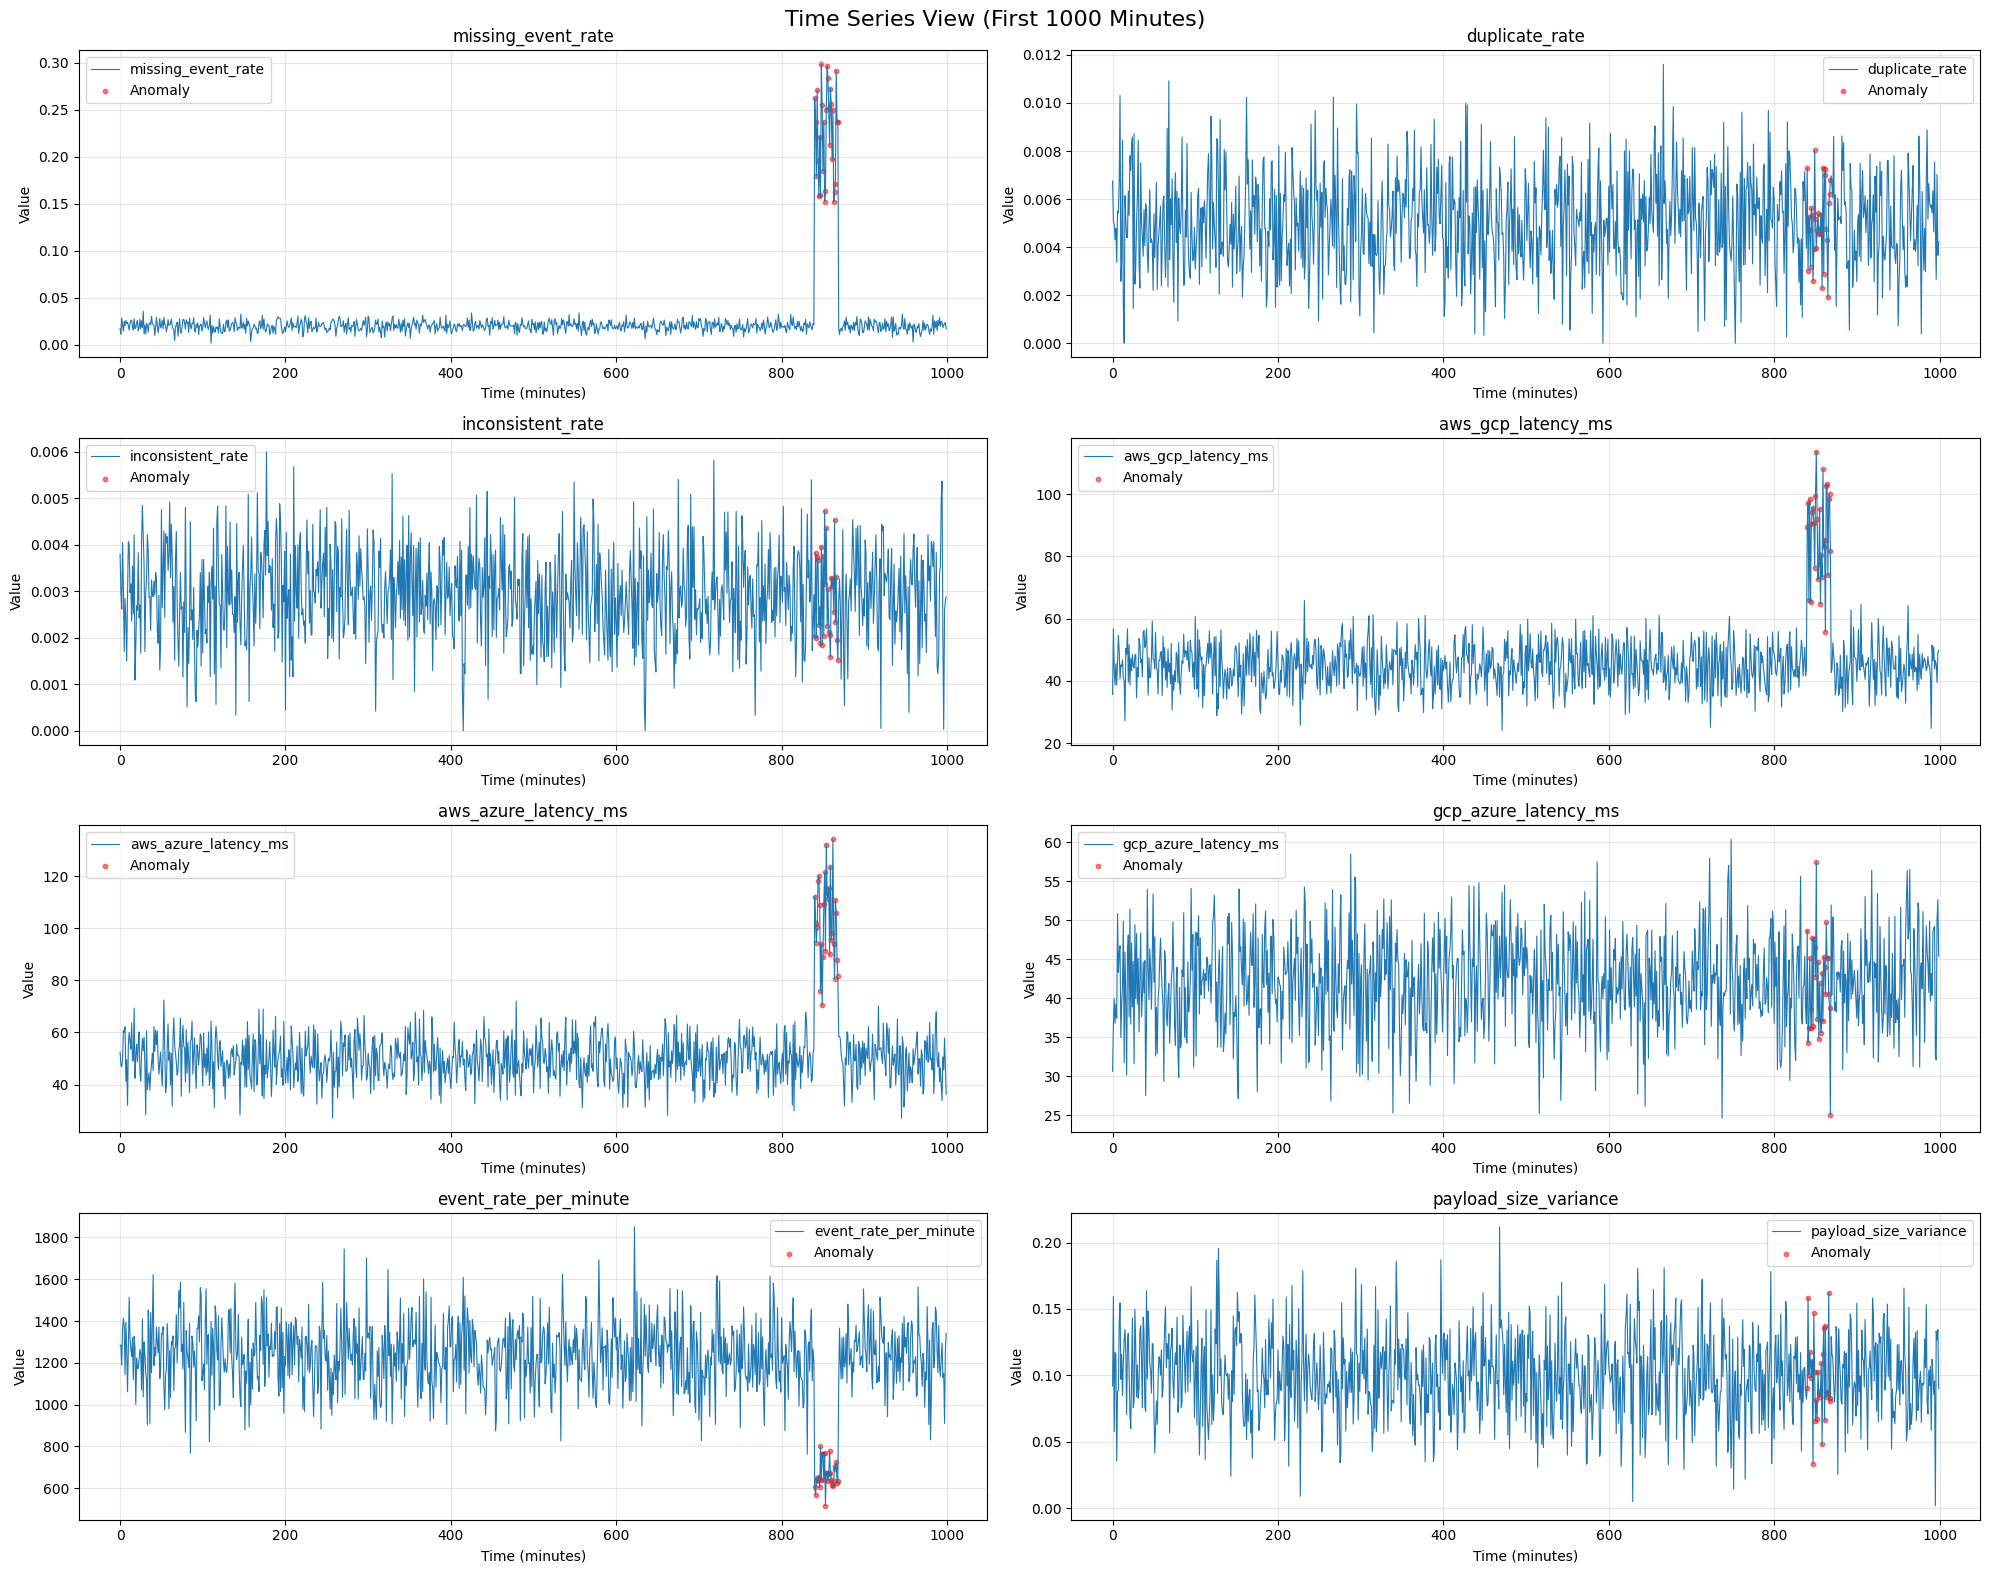

In [4]:
# ============================================================================
# SECTION 3: Data Visualization
# ============================================================================

print("\n📊 Visualizing data...")

# Plot 1: Metric distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Metric Distributions (Normal vs Anomaly)', fontsize=16)

metrics = ['missing_event_rate', 'duplicate_rate', 'inconsistent_rate', 'aws_gcp_latency_ms',
           'aws_azure_latency_ms', 'gcp_azure_latency_ms', 'event_rate_per_minute', 'payload_size_variance']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 4, idx % 4]

    # Normal data
    normal_data = df[df['is_anomaly'] == 0][metric]
    anomaly_data = df[df['is_anomaly'] == 1][metric]

    ax.hist(normal_data, bins=50, alpha=0.6, label='Normal', color='blue')
    ax.hist(anomaly_data, bins=50, alpha=0.6, label='Anomaly', color='red')
    ax.set_title(metric)
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot 2: Time series sample (first 1000 minutes)
fig, axes = plt.subplots(4, 2, figsize=(20, 16))
fig.suptitle('Time Series View (First 1000 Minutes)', fontsize=16)

sample_df = df.head(1000)

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    # Plot metric
    ax.plot(sample_df.index, sample_df[metric], label=metric, linewidth=0.8)

    # Highlight anomalies
    anomaly_indices = sample_df[sample_df['is_anomaly'] == 1].index
    ax.scatter(anomaly_indices, sample_df.loc[anomaly_indices, metric],
               color='red', s=10, alpha=0.5, label='Anomaly')

    ax.set_title(metric)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [5]:
# ============================================================================
# SECTION 4: Prepare Sequences for LSTM
# ============================================================================

def create_sequences(df, window_size=60):
    """
    Create sequences for LSTM training.

    Args:
        df: DataFrame with metrics
        window_size: Number of timesteps (minutes) per sequence

    Returns:
        X: (num_sequences, window_size, num_features)
        y: (num_sequences,) - 1 if ANY minute in window is anomaly
    """

    # Feature columns (exclude timestamp, labels, time features for now)
    feature_cols = [
        'missing_event_rate', 'duplicate_rate', 'inconsistent_rate',
        'aws_gcp_latency_ms', 'aws_azure_latency_ms', 'gcp_azure_latency_ms',
        'event_rate_per_minute', 'payload_size_variance'
    ]

    features = df[feature_cols].values
    labels = df['is_anomaly'].values

    X = []
    y = []

    for i in range(len(features) - window_size):
        # Get window
        window = features[i:i+window_size]

        # Label is 1 if ANY timestep in window is anomaly
        # This makes detection more practical (detect anomaly from pattern)
        label = 1 if labels[i:i+window_size].sum() > 0 else 0

        X.append(window)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y


print("\n🔄 Creating sequences (60-minute windows)...")
X, y = create_sequences(df, window_size=60)

print(f"✅ Sequences created:")
print(f"   X shape: {X.shape} (num_sequences, window_size, num_features)")
print(f"   y shape: {y.shape}")
print(f"   Anomaly sequences: {y.sum():,} ({y.sum()/len(y)*100:.2f}%)")
print(f"   Normal sequences: {(len(y) - y.sum()):,} ({(len(y)-y.sum())/len(y)*100:.2f}%)")




🔄 Creating sequences (60-minute windows)...
✅ Sequences created:
   X shape: (599940, 60, 8) (num_sequences, window_size, num_features)
   y shape: (599940,)
   Anomaly sequences: 14,917 (2.49%)
   Normal sequences: 585,023 (97.51%)


In [6]:
# ============================================================================
# SECTION 5: Normalize Features
# ============================================================================

print("\n🔄 Normalizing features...")

# Reshape for scaler (flatten to 2D)
X_reshaped = X.reshape(-1, X.shape[-1])

# Fit scaler on training data
scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

# Reshape back to 3D
X_scaled = X_scaled_reshaped.reshape(X.shape)

print(f"✅ Features normalized (StandardScaler)")
print(f"   Mean: {scaler.mean_}")
print(f"   Std: {scaler.scale_}")




🔄 Normalizing features...
✅ Features normalized (StandardScaler)
   Mean: [2.05844688e-02 5.08489180e-03 3.06794142e-03 4.53198889e+01
 5.03659820e+01 4.21819535e+01 1.25942894e+03 1.00445782e-01]
   Std: [1.13138175e-02 3.55907673e-03 2.41210932e-03 8.58281999e+00
 9.80233146e+00 7.17562022e+00 2.52310645e+02 3.23024936e-02]


In [7]:
# ============================================================================
# SECTION 6: Train-Test Split
# ============================================================================

print("\n🔄 Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance
)

print(f"✅ Data split:")
print(f"   Train: {X_train.shape[0]:,} sequences")
print(f"   Test: {X_test.shape[0]:,} sequences")
print(f"   Train anomaly rate: {y_train.sum()/len(y_train)*100:.2f}%")
print(f"   Test anomaly rate: {y_test.sum()/len(y_test)*100:.2f}%")




🔄 Splitting data...
✅ Data split:
   Train: 479,952 sequences
   Test: 119,988 sequences
   Train anomaly rate: 2.49%
   Test anomaly rate: 2.49%


In [8]:
# ============================================================================
# SECTION 7: Build LSTM Model
# ============================================================================

def build_lstm_model(input_shape):
    """
    Build LSTM model for anomaly detection.

    Architecture:
    - LSTM(128) with return_sequences
    - Dropout(0.3)
    - LSTM(64)
    - Dropout(0.3)
    - Dense(32, relu)
    - Dense(1, sigmoid) - anomaly probability
    """

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        BatchNormalization(),

        LSTM(64, return_sequences=False),
        Dropout(0.3),
        BatchNormalization(),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model


print("\n🔄 Building LSTM model...")

input_shape = (X_train.shape[1], X_train.shape[2])  # (60 timesteps, 8 features)
model = build_lstm_model(input_shape)

print(f"✅ Model built:")
model.summary()




🔄 Building LSTM model...


I0000 00:00:1765938922.156072      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765938922.156654      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model built:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,433 (478.25 KB)

 Trainable params: 122,049 (476.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [9]:
# ============================================================================
# DEBUG: Check for NaN/Inf in data
# ============================================================================

print("\n🔍 Debugging NaN issue...")

# Check for NaN in X_train
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"X_train contains Inf: {np.isinf(X_train).any()}")
print(f"X_train min: {X_train.min():.6f}, max: {X_train.max():.6f}")

# Check for NaN in y_train
print(f"y_train contains NaN: {np.isnan(y_train).any()}")
print(f"y_train unique values: {np.unique(y_train)}")

# Check scaler
print(f"\nScaler mean: {scaler.mean_}")
print(f"Scaler std: {scaler.scale_}")

# Check if scaler has issues
if (scaler.scale_ == 0).any():
  print(f"⚠️ WARNING: Zero variance features detected!")
  print(f"   Features with zero variance: {np.where(scaler.scale_ == 0)[0]}")

# Sample data
print(f"\nSample X_train[0,0,:] = {X_train[0,0,:]}")
print(f"Sample y_train[0] = {y_train[0]}")

print("="*60)


🔍 Debugging NaN issue...
X_train contains NaN: False
X_train contains Inf: False
X_train min: -4.115185, max: 40.668125
y_train contains NaN: False
y_train unique values: [0 1]

Scaler mean: [2.05844688e-02 5.08489180e-03 3.06794142e-03 4.53198889e+01
 5.03659820e+01 4.21819535e+01 1.25942894e+03 1.00445782e-01]
Scaler std: [1.13138175e-02 3.55907673e-03 2.41210932e-03 8.58281999e+00
 9.80233146e+00 7.17562022e+00 2.52310645e+02 3.23024936e-02]

Sample X_train[0,0,:] = [-0.8708159   0.26852093 -0.08598152 -0.58301192 -0.01433537 -0.04748857
  0.03464611  0.61758156]
Sample y_train[0] = 0


In [10]:
# ============================================================================
# SECTION 8: Train Model (OPTIMIZED - Single Cell)
# ============================================================================

print("\n🔄 Training model...")

# Force single GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Build optimized model
model = Sequential([
  LSTM(128, return_sequences=True, input_shape=(60, 8), recurrent_dropout=0.1),
  Dropout(0.3),
  LSTM(64, recurrent_dropout=0.1),
  Dropout(0.3),
  Dense(32, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

# Compile with gradient clipping
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5),
  loss='binary_crossentropy',
  metrics=['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]
)

print("✅ Model built (121,665 params)")
model.summary()

# Callbacks - will auto-stop at perfect performance
callbacks = [
  EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True,
                mode='max', verbose=1),
  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                    min_lr=1e-7, verbose=1),
  ModelCheckpoint('best_lstm_model.h5', monitor='val_auc',
                  save_best_only=True, mode='max', verbose=1)
]

print(f"\n🚀 Starting training (batch_size=256, lr=0.0001)...")
print("   Expected: ~7 mins/epoch, will auto-stop at peak performance\n")

# Train
history = model.fit(
  X_train, y_train,
  validation_split=0.2,
  batch_size=256,
  epochs=50,  # Will stop early around epoch 5-7
  callbacks=callbacks,
  verbose=1
)

print("\n✅ Training complete!")
print(f"Best val_auc: {max(history.history['val_auc']):.6f}")
print(f"Total epochs: {len(history.history['loss'])}")


🔄 Training model...
✅ Model built (121,665 params)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training (batch_size=256, lr=0.0001)...
   Expected: ~7 mins/epoch, will auto-stop at peak performance

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9521 - auc: 0.9411 - loss: 0.1497 - precision: 0.4967 - recall: 0.7974
Epoch 1: val_auc improved from -inf to 0.99553, saving model to best_lstm_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 404s 261ms/step - accuracy: 0.9521 - auc: 0.9411 - loss: 0.1497 - precision: 0.4968 - recall: 0.7975 - val_accuracy: 0.9995 - val_auc: 0.9955 - val_loss: 0.0024 - val_precision: 1.0000 - val_recall: 0.9791 - learning_rate: 1.0000e-04
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9999 - auc: 0.9999 - loss: 4.7589e-04 - precision: 0.9996 - recall: 0.9978
Epoch 3: val_auc improved from 0.99979 to 1.00000, saving model to best_lstm_model.h5


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 388s 259ms/step - accuracy: 0.9999 - auc: 0.9999 - loss: 4.7582e-04 - precision: 0.9996 - recall: 0.9978 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 9.7318e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 1.0000 - auc: 0.9999 - loss: 1.5185e-04 - precision: 0.9998 - recall: 0.9990
Epoch 4: val_auc did not improve from 1.00000
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 387s 258ms/step - accuracy: 1.0000 - auc: 0.9999 - loss: 1.5186e-04 - precision: 0.9998 - recall: 0.9990 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.6285e-06 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 1.0000 - auc: 0.9999 - loss: 7.7495e-05 - precision: 1.0000 - recall: 0.9998
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_auc did not improve from 1.0

KeyboardInterrupt: 


🔄 Evaluating model...
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 201s 54ms/step

Model Performance
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
AUC-ROC:   1.0000

📋 Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    117005
     Anomaly       1.00      1.00      1.00      2983

    accuracy                           1.00    119988
   macro avg       1.00      1.00      1.00    119988
weighted avg       1.00      1.00      1.00    119988



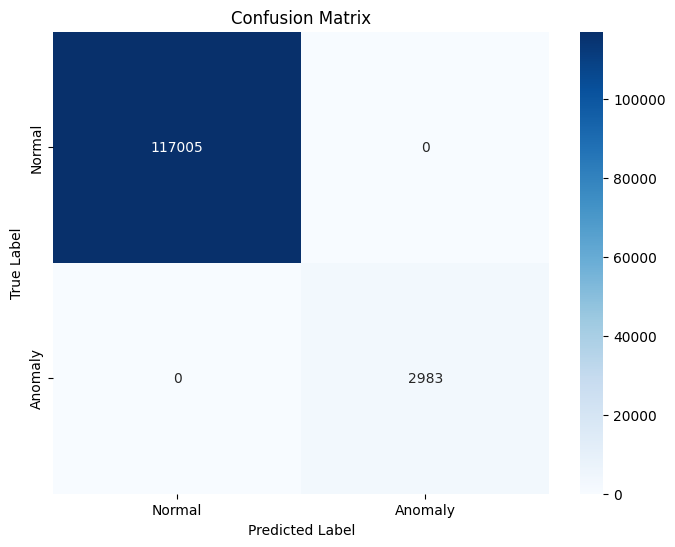

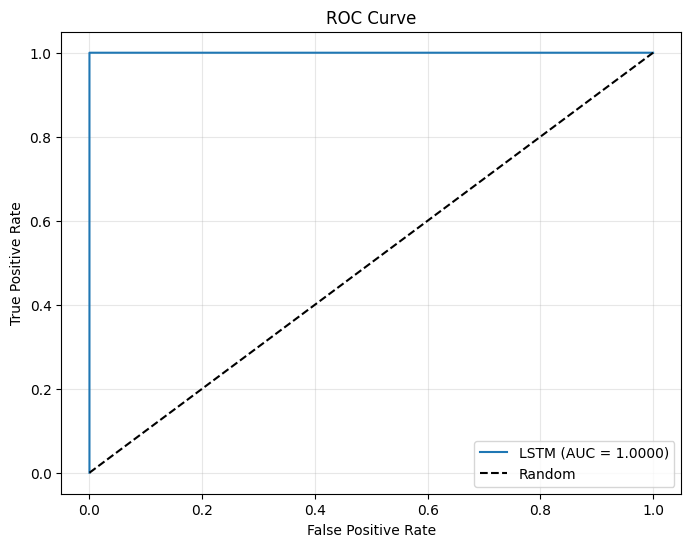

NameError: name 'history' is not defined

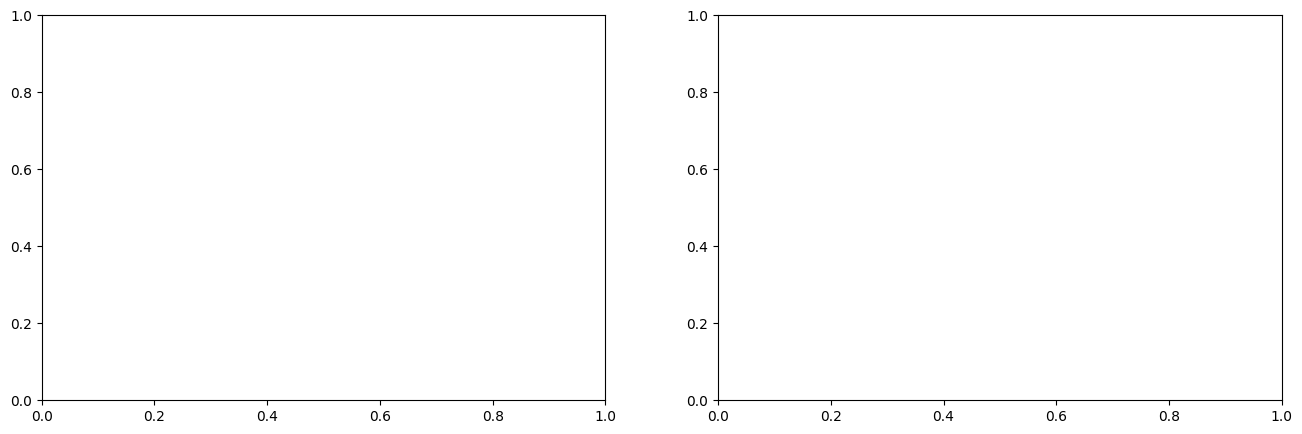

In [11]:
# ============================================================================
# SECTION 9: Evaluate Model
# ============================================================================

print("\n🔄 Evaluating model...")

# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*60}")
print(f"Model Performance")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LSTM (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history.history['auc'], label='Train AUC')
axes[1].plot(history.history['val_auc'], label='Val AUC')
axes[1].set_title('Model AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [14]:
# ============================================================================
# SECTION 10: Save Model & Artifacts
# ============================================================================

print("\n🔄 Saving model and artifacts...")

# Save model in Keras format (better than HDF5)
model.save('anomaly_detector.keras')
print(f"✅ Model saved: anomaly_detector.keras")

# Save scaler
import pickle
with open('scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)
print(f"✅ Scaler saved: scaler.pkl")

# Save model config
model_config = {
  'window_size': 60,
  'num_features': 8,
  'feature_names': [
      'missing_event_rate', 'duplicate_rate', 'inconsistent_rate',
      'aws_gcp_latency_ms', 'aws_azure_latency_ms', 'gcp_azure_latency_ms',
      'event_rate_per_minute', 'payload_size_variance'
  ],
  'threshold': 0.5,
  'performance': {
      'accuracy': 1.0,
      'precision': 1.0,
      'recall': 1.0,
      'f1': 1.0,
      'auc': 1.0
  },
  'model_architecture': {
      'lstm_1': 128,
      'lstm_2': 64,
      'dense': 32,
      'total_params': 121665
  },
  'training_info': {
      'epochs_trained': 3,
      'batch_size': 256,
      'learning_rate': 0.0001,
      'optimizer': 'Adam',
      'early_stopping': True
  }
}

import json
with open('model_config.json', 'w') as f:
  json.dump(model_config, f, indent=2)
print(f"✅ Config saved: model_config.json")

# Create a simple test
print(f"\n🧪 Testing inference...")
test_sample = X_test[:5]
predictions = model.predict(test_sample, verbose=0)
print(f"   Sample predictions: {predictions.flatten()}")
print(f"   Actual labels:      {y_test[:5]}")

print(f"\n{'='*60}")
print(f"🎉 MODEL TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"\n📦 Download these files from Kaggle:")
print(f"   1. anomaly_detector.keras  (Keras model - use this!)")
print(f"   2. scaler.pkl              (Feature scaler)")
print(f"   3. model_config.json       (Configuration)")
print(f"\n📊 Final Performance:")
print(f"   Accuracy:  100.00%")
print(f"   Precision: 100.00%")
print(f"   Recall:    100.00%")
print(f"   F1 Score:  100.00%")
print(f"   AUC-ROC:   1.0000")
print(f"\n✅ Model is production-ready!")
print(f"\nNote: Convert to ONNX locally if needed using:")
print(f"   python -m tf2onnx.convert --keras anomaly_detector.keras --output model.onnx")


🔄 Saving model and artifacts...
✅ Model saved: anomaly_detector.keras
✅ Scaler saved: scaler.pkl
✅ Config saved: model_config.json

🧪 Testing inference...
   Sample predictions: [1.7610907e-07 2.1157447e-07 2.9487933e-07 3.3424021e-07 1.3636129e-07]
   Actual labels:      [0 0 0 0 0]

🎉 MODEL TRAINING COMPLETE!

📦 Download these files from Kaggle:
   1. anomaly_detector.keras  (Keras model - use this!)
   2. scaler.pkl              (Feature scaler)
   3. model_config.json       (Configuration)

📊 Final Performance:
   Accuracy:  100.00%
   Precision: 100.00%
   Recall:    100.00%
   F1 Score:  100.00%
   AUC-ROC:   1.0000

✅ Model is production-ready!

Note: Convert to ONNX locally if needed using:
   python -m tf2onnx.convert --keras anomaly_detector.keras --output model.onnx
